In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error

In [172]:
df = pd.read_csv(
    "exchange_rate.csv",
    parse_dates=["date"],
    dayfirst=True,
    index_col="date"
)
print(df.info())
print(df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB
None
(7588, 1)


,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


# 1. Data Processing and Exploration

In [173]:
print(df.isnull().sum())
print(df.duplicated().sum())

Ex_rate    0
dtype: int64
2258


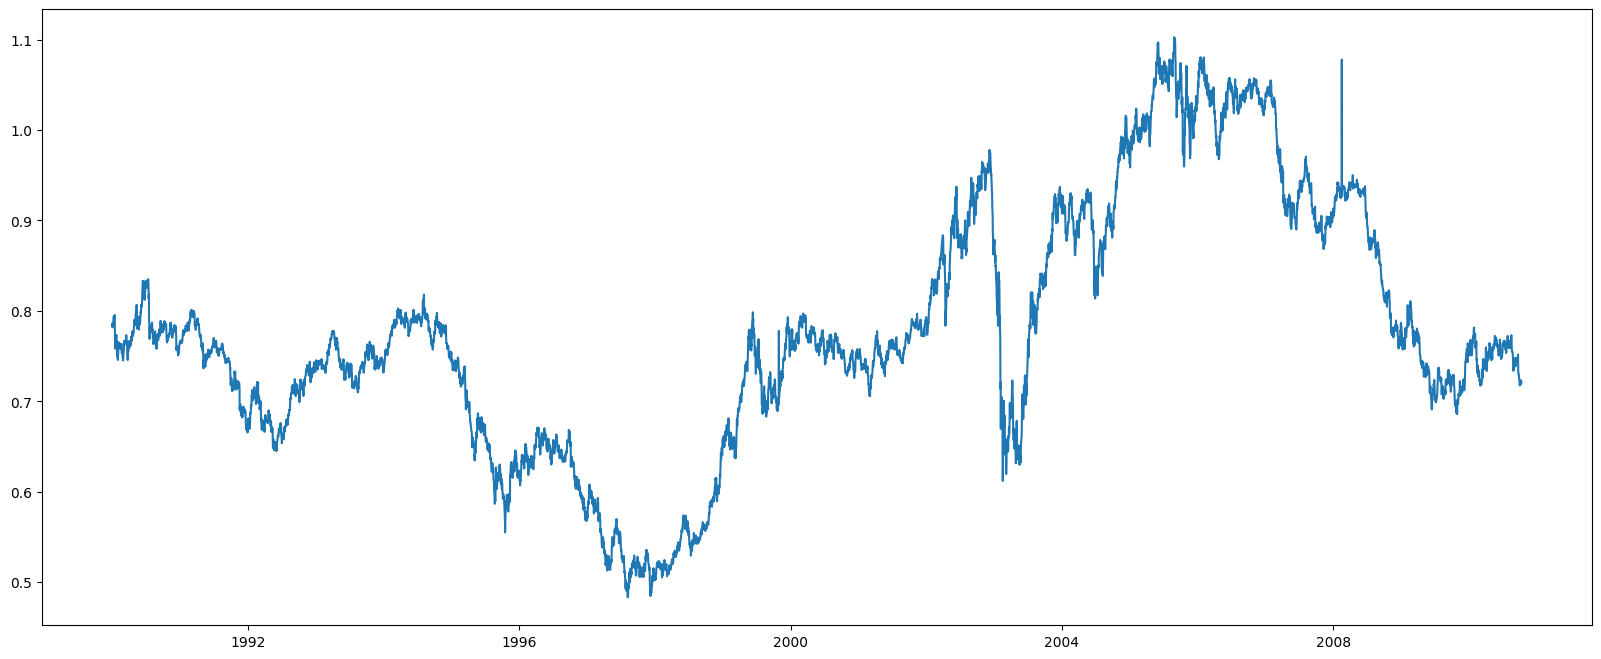

In [174]:
plt.figure(figsize=(20,8))
plt.plot(df)

<Axes: xlabel='date'>

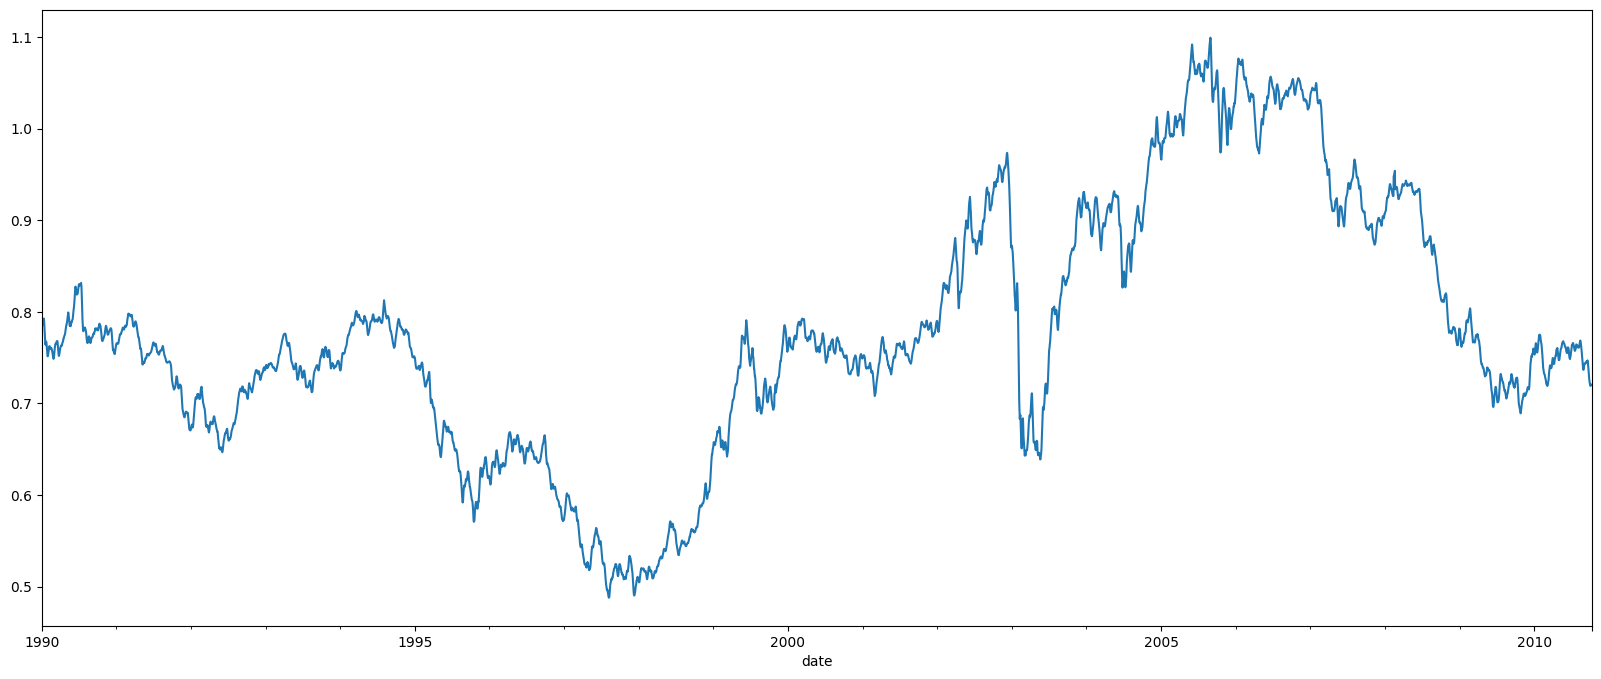

In [175]:
result = seasonal_decompose(df['Ex_rate'], model="multiplicative")
plt.figure(figsize=(20,8))
result.trend.plot()

<Axes: xlabel='date'>

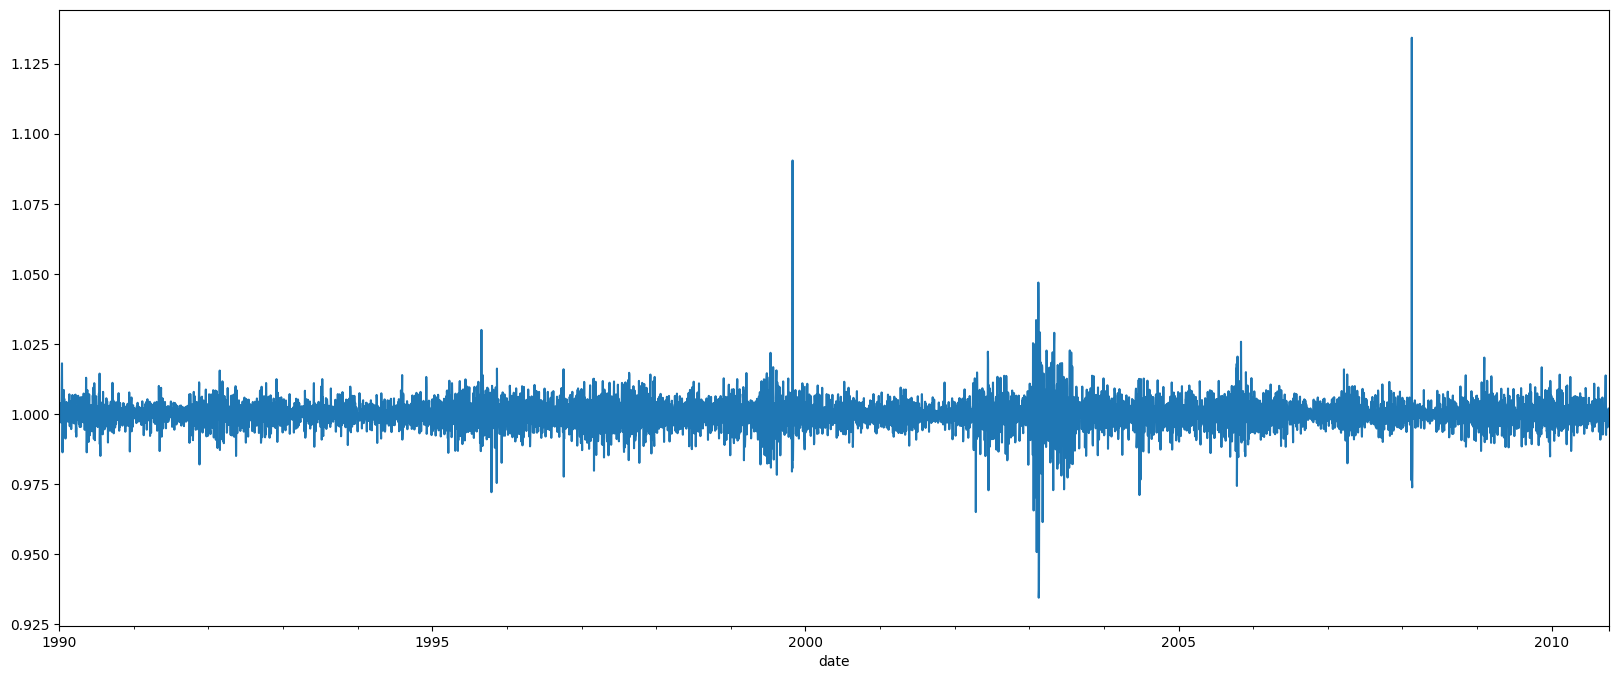

In [176]:
plt.figure(figsize=(20,8))
result.resid.plot()

<Axes: xlabel='date'>

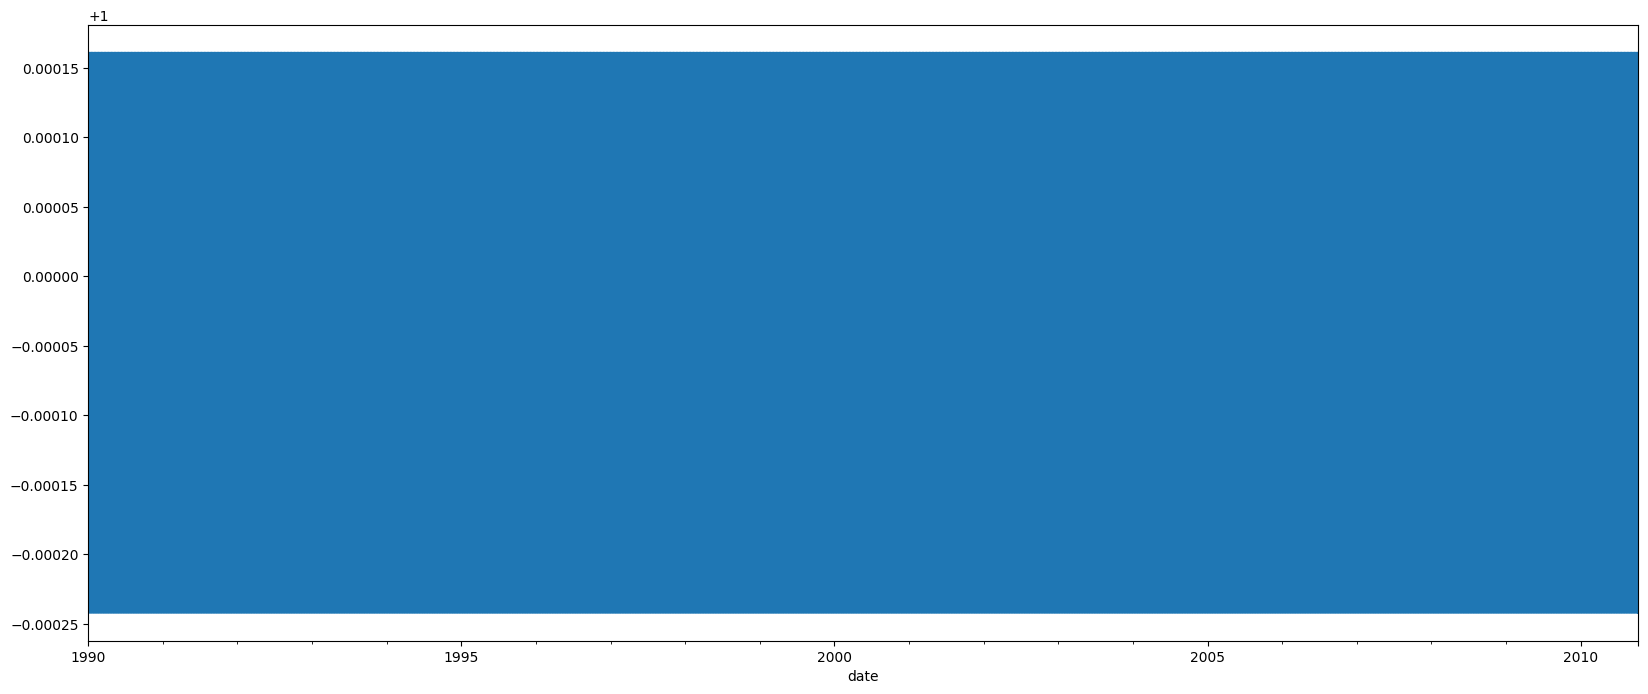

In [177]:
plt.figure(figsize=(20,8))
result.seasonal.plot()

With the above plots, we can observe that the given data is not a seasonal data

# 2. Model Building

In [178]:
def test_stationarity(timeseries_col):

    #Calculate rolling mean and rolling standard deviation
    rolmean = timeseries_col.rolling(window = 12).mean()
    rolstd = timeseries_col.rolling(window = 12).std()
    plt.figure(figsize=(20,8))
    original = plt.plot(timeseries_col, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'green', label = 'Rolling Std')
    plt.legend(loc='best')


    print('Results of Dickey-Fuller Test :\n')
    df_test = adfuller(timeseries_col)
    my_output = pd.Series(df_test[0:4], index =['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for i,j in df_test[4].items():
        my_output['Critical Value (%s)'%i] =j
    print(my_output)

Results of Dickey-Fuller Test :

Test Statistic                   -1.664994
p-value                           0.449233
#Lags Used                        1.000000
Number of Observations Used    7586.000000
Critical Value (1%)              -3.431212
Critical Value (5%)              -2.861921
Critical Value (10%)             -2.566973
dtype: float64


'\n\n - We can observe that the Test Statistic value  is -1.66 which is not more than the critical value at 5%, i.e., -2.86.\n - We can also observe that the p-value is less than the alpha value at 5 percent, 0.5. \nBy the above observations we can come to a conclusion to make the data more stationary\n'

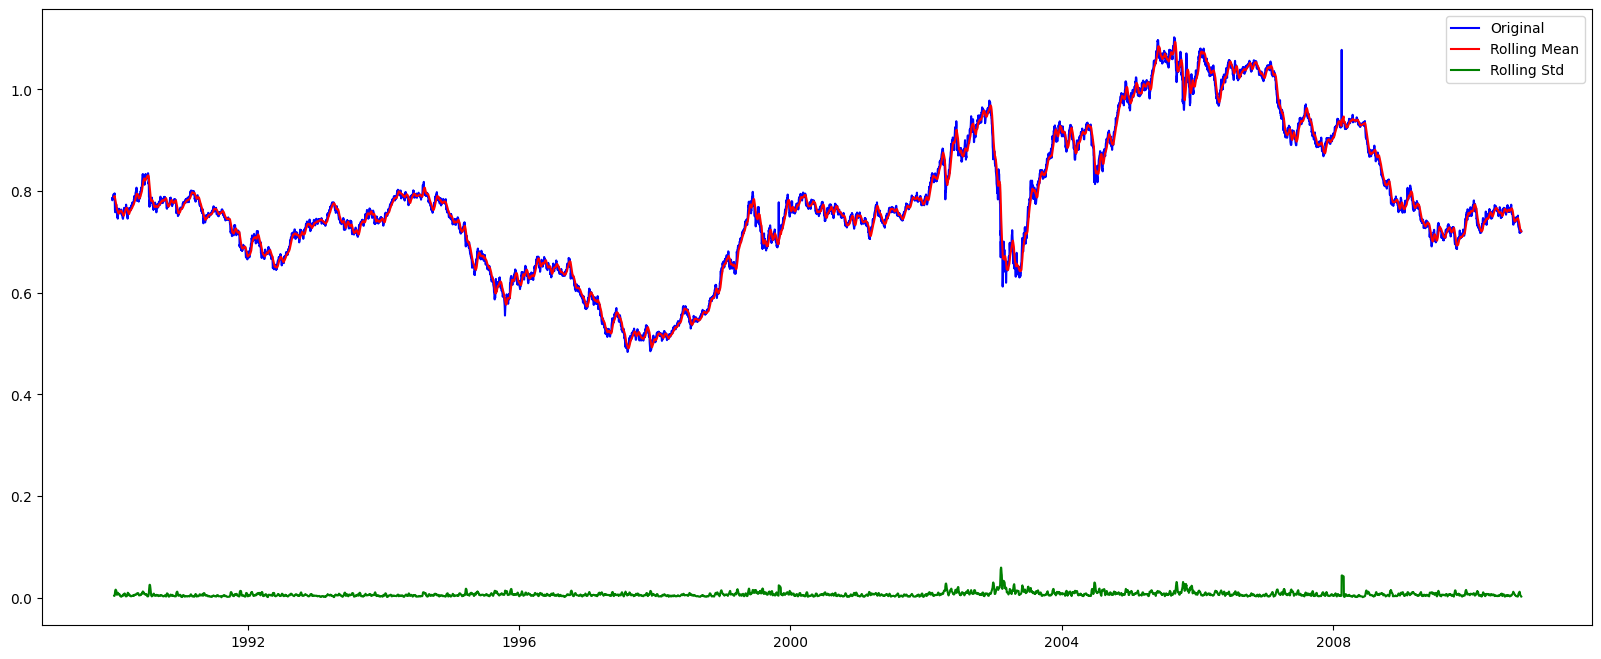

In [179]:
test_stationarity(df['Ex_rate'])

'''

 - We can observe that the Test Statistic value  is -1.66 which is not more than the critical value at 5%, i.e., -2.86.
 - We can also observe that the p-value is less than the alpha value at 5 percent, 0.5. 
By the above observations we can come to a conclusion to make the data more stationary
'''

In [180]:
'''
Differencing
'''

df['Ex_Rate_Diff']= df['Ex_rate']-df['Ex_rate'].shift(12)
df.dropna(inplace=True)

Results of Dickey-Fuller Test :

Test Statistic                -1.056518e+01
p-value                        7.549185e-19
#Lags Used                     3.600000e+01
Number of Observations Used    7.539000e+03
Critical Value (1%)           -3.431218e+00
Critical Value (5%)           -2.861923e+00
Critical Value (10%)          -2.566974e+00
dtype: float64


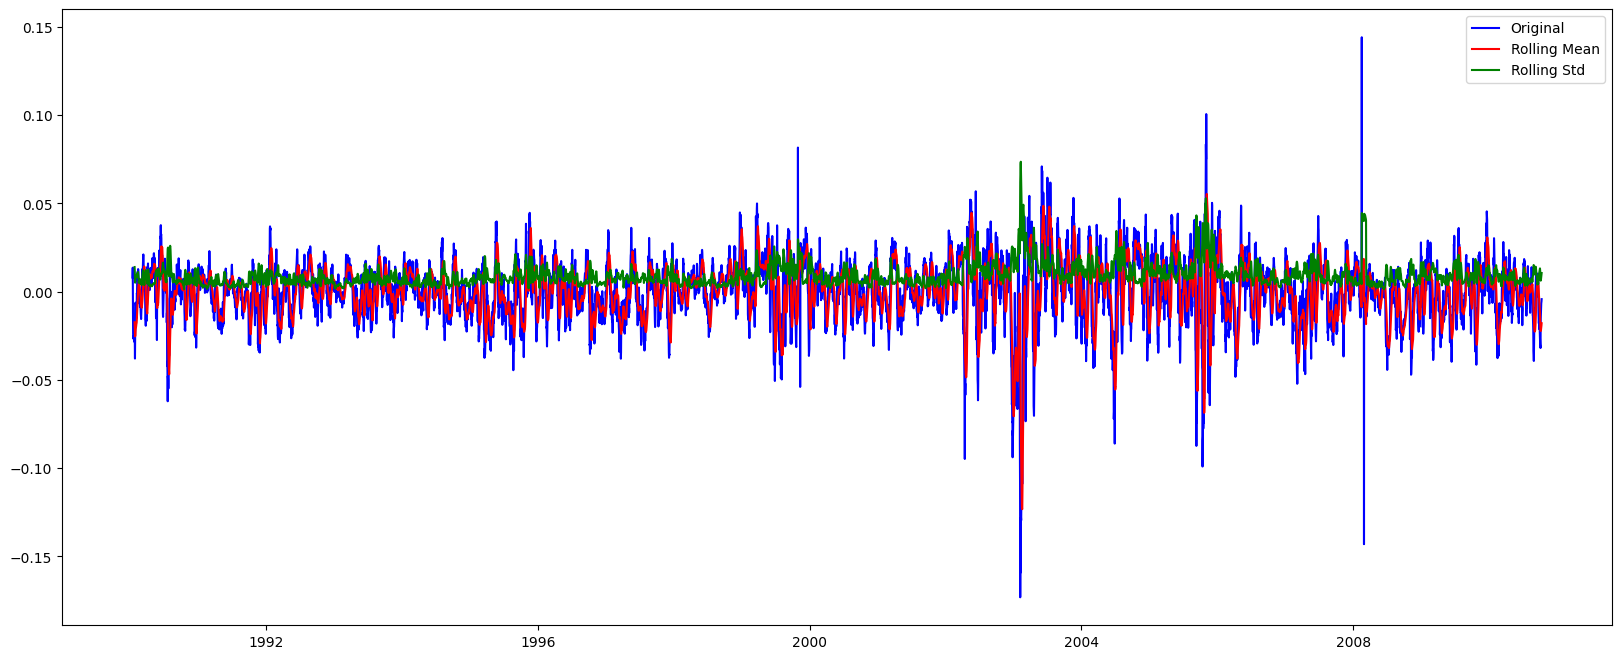

In [181]:
test_stationarity(df['Ex_Rate_Diff'])

<Figure size 2000x800 with 0 Axes>

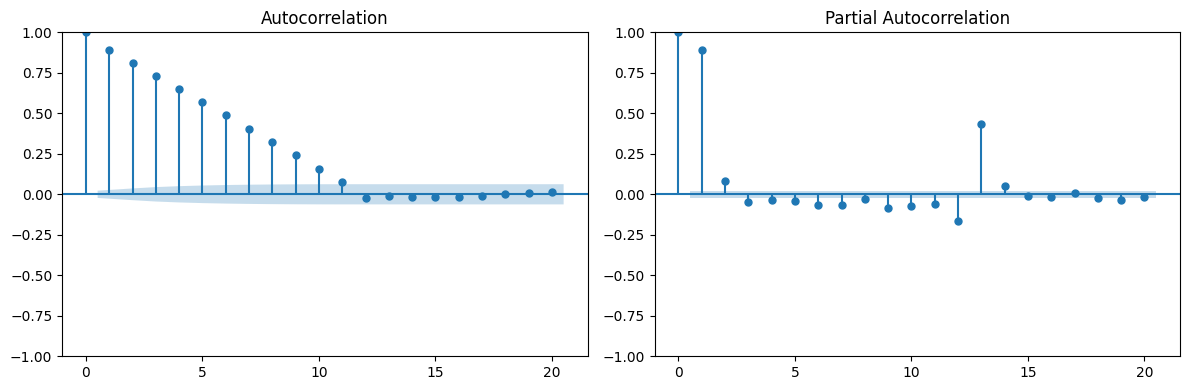

In [182]:
'''
Checking the acf and pacf limits
'''

plt.figure(figsize=(20,8))
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(df['Ex_Rate_Diff'], lags=20, ax=axes[0])
smt.graphics.plot_pacf(df['Ex_Rate_Diff'], lags=20, ax=axes[1])
plt.tight_layout()

In [183]:
'''

 - ACF range - (1 - 11)
 - PACF range - (1 - 2)
'''

'\n\n - ACF range - (1 - 11)\n - PACF range - (1 - 2)\n'

In [184]:
model = ARIMA(df['Ex_rate'], order=(5,1,1))


c:\Users\Karthik\Desktop\Excelr\Python\Assignments\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Karthik\Desktop\Excelr\Python\Assignments\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Karthik\Desktop\Excelr\Python\Assignments\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [185]:
result = model.fit()

In [186]:
df['predicted_arima'] = result.predict()

In [187]:

forecast = result.forecast(1000)
forecast[:50]

2010-10-11    0.720805
2010-10-12    0.720883
2010-10-13    0.720891
2010-10-14    0.720865
2010-10-15    0.720866
2010-10-16    0.720865
2010-10-17    0.720866
2010-10-18    0.720866
2010-10-19    0.720866
2010-10-20    0.720866
2010-10-21    0.720866
2010-10-22    0.720866
2010-10-23    0.720866
2010-10-24    0.720866
2010-10-25    0.720866
2010-10-26    0.720866
2010-10-27    0.720866
2010-10-28    0.720866
2010-10-29    0.720866
2010-10-30    0.720866
2010-10-31    0.720866
2010-11-01    0.720866
2010-11-02    0.720866
2010-11-03    0.720866
2010-11-04    0.720866
2010-11-05    0.720866
2010-11-06    0.720866
2010-11-07    0.720866
2010-11-08    0.720866
2010-11-09    0.720866
2010-11-10    0.720866
2010-11-11    0.720866
2010-11-12    0.720866
2010-11-13    0.720866
2010-11-14    0.720866
2010-11-15    0.720866
2010-11-16    0.720866
2010-11-17    0.720866
2010-11-18    0.720866
2010-11-19    0.720866
2010-11-20    0.720866
2010-11-21    0.720866
2010-11-22    0.720866
2010-11-23 

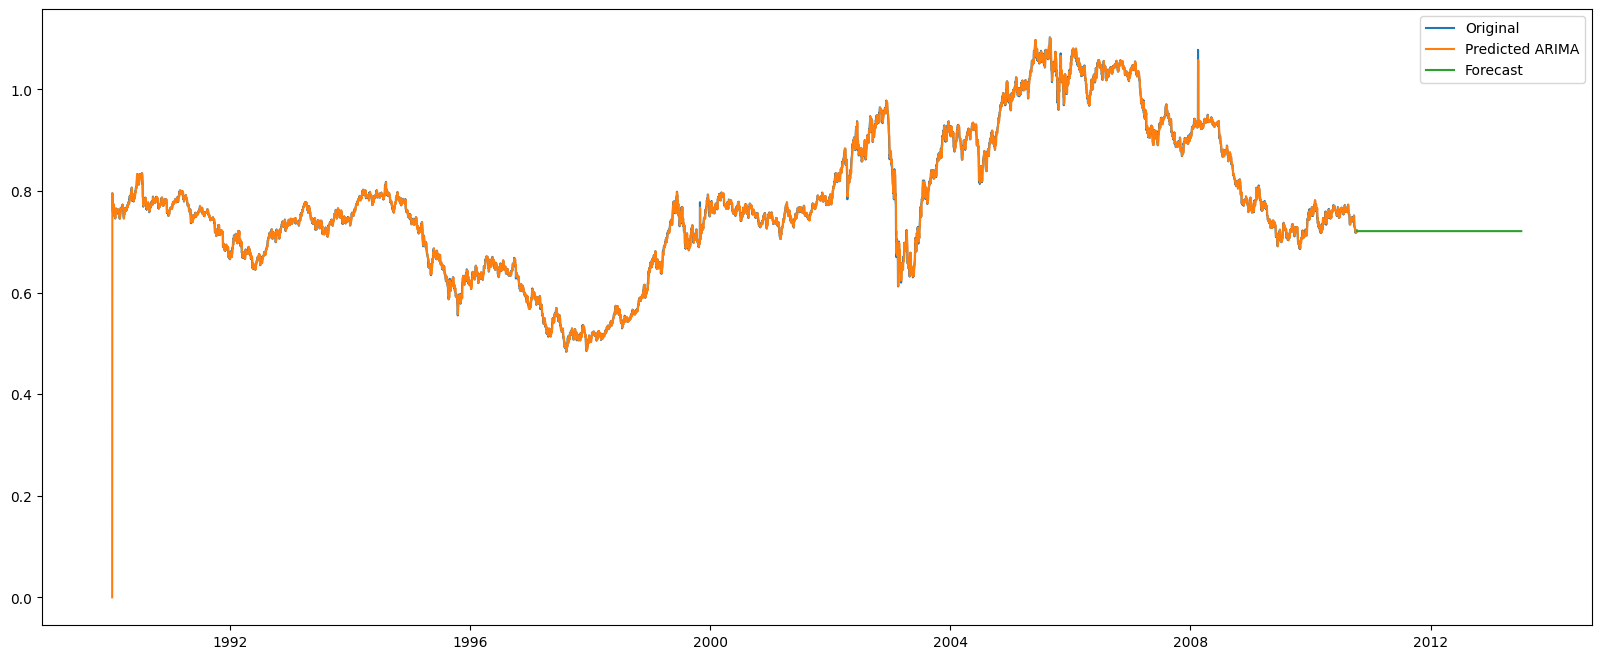

In [188]:
plt.figure(figsize=(20,8))
plt.plot(df['Ex_rate'],label='Original')
plt.plot(df['predicted_arima'],label='Predicted ARIMA')
plt.plot(forecast,label='Forecast')
plt.legend()

# 3. Model SARIMAX

In [189]:
Model = SARIMAX(df['Ex_rate'],order=(5,1,1),seasonal_order=(1,1,1,12))
results_sarimax = Model.fit()
sar_pred = results_sarimax.predict()
df['predicted_sarimax'] = results_sarimax.predict()


c:\Users\Karthik\Desktop\Excelr\Python\Assignments\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Karthik\Desktop\Excelr\Python\Assignments\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Karthik\Desktop\Excelr\Python\Assignments\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [190]:
sar_fore = results_sarimax.forecast(1000)

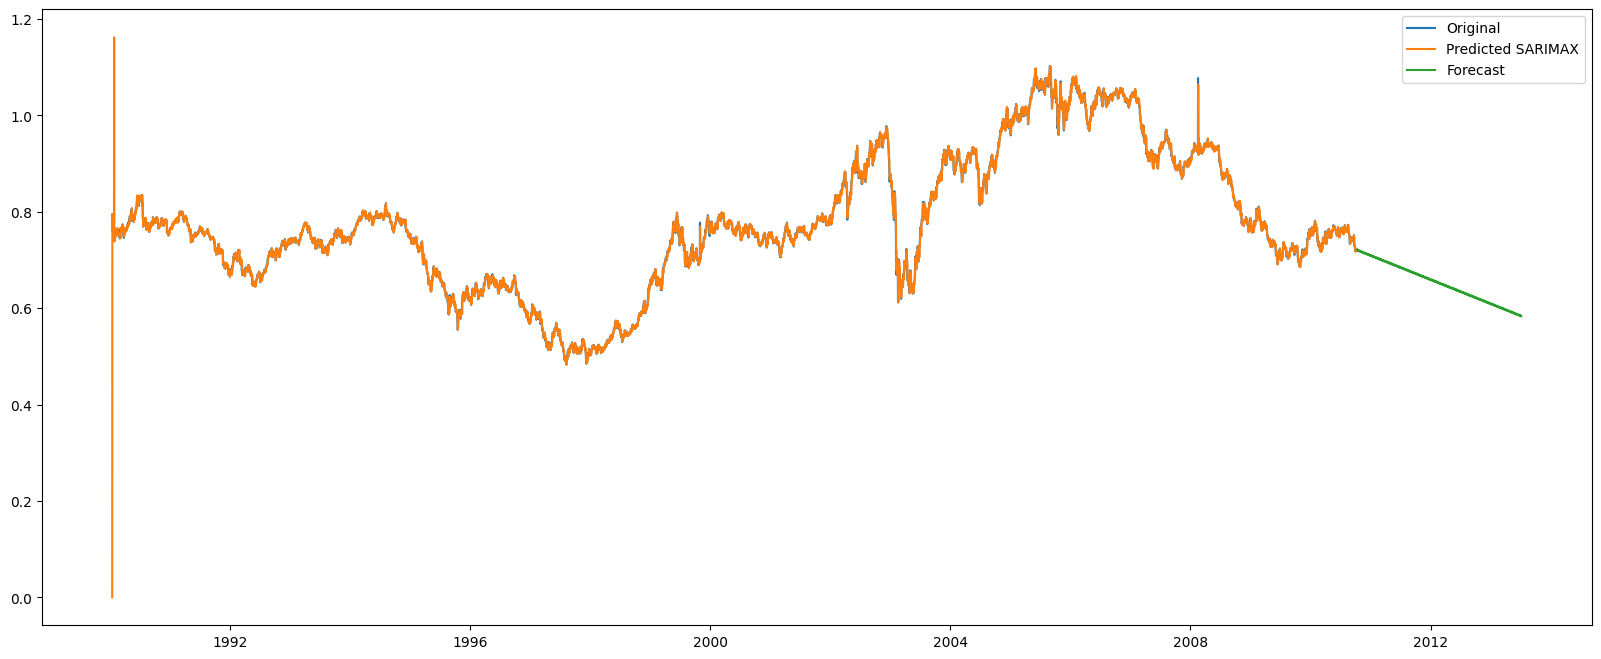

In [191]:
plt.figure(figsize=(20,8))
plt.plot(df['Ex_rate'],label='Original')
plt.plot(df['predicted_sarimax'],label='Predicted SARIMAX')
plt.plot(sar_fore,label='Forecast')
plt.legend()

In [192]:
print("*"*100)
print("ARIMA")
print("*"*100)
print("Mean Absolute Error =",mean_absolute_error(df['Ex_rate'], df['predicted_arima']))
print("Mean Absolute Percentage error =",mean_absolute_percentage_error(df['Ex_rate'], df['predicted_arima'])*100)
print("Mean Squared error =",mean_squared_error(df['Ex_rate'], df['predicted_arima']))
print("*"*100)
print("SARIMAX")
print("*"*100)
print("Mean Absolute Error =",mean_absolute_error(df['Ex_rate'], df['predicted_sarimax']))
print("Mean Absolute Percentage error =",mean_absolute_percentage_error(df['Ex_rate'], df['predicted_sarimax'])*100)
print("Mean Squared error =",mean_squared_error(df['Ex_rate'], df['predicted_sarimax']))
print("*"*100)

****************************************************************************************************
ARIMA
****************************************************************************************************
Mean Absolute Error = 0.0038007994263181033
Mean Absolute Percentage error = 0.49556857641940044
Mean Squared error = 0.00011909319921094976
****************************************************************************************************
SARIMAX
****************************************************************************************************
Mean Absolute Error = 0.003942746059057637
Mean Absolute Percentage error = 0.5135067967927595
Mean Squared error = 0.00014079016698779798
****************************************************************************************************


In [ ]:
'''
By looking at the results and calculating the errors
 - ARIMA model seems to be providing the better results

ARIMA
****************************************************************************************************
Mean Absolute Error = 0.0038007994263181033
Mean Absolute Percentage error = 0.49556857641940044
Mean Squared error = 0.00011909319921094976


SARIMAX
****************************************************************************************************
Mean Absolute Error = 0.003942746059057637
Mean Absolute Percentage error = 0.5135067967927595
Mean Squared error = 0.00014079016698779798
****************************************************************************************************

'''

'\nBy looking at the results and calculating the errors\n - ARIMA model seems to be providing the better results\n\n****************************************************************************************************\nARIMA\n****************************************************************************************************\nMean Absolute Error = 0.0038007994263181033\nMean Absolute Percentage error = 0.49556857641940044\nMean Squared error = 0.00011909319921094976\n****************************************************************************************************\nSARIMAX\n****************************************************************************************************\nMean Absolute Error = 0.003942746059057637\nMean Absolute Percentage error = 0.5135067967927595\nMean Squared error = 0.00014079016698779798\n****************************************************************************************************\n\n'